In [1]:
import pickle
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import time
os.chdir('/Users/panzhang/Desktop/CS498AML/HW4/cifar-10-batches-py')

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
batchName = [i for i in os.listdir() if 'data_batch' in i]
for i in batchName:
    globals()[i] = unpickle(i)

In [4]:
classLevels = set()
df_class = {}
for eachBatch in batchName:
    # get all class levels
    classLevels = classLevels.union(set(globals()[eachBatch][b'labels']))
    # initialize - create null dataframes
    for classValue in classLevels:
        df_class[classValue] = pd.DataFrame(columns = list(range(0, 3072, 1)))

In [5]:
def sepPickleClass(batch, classValueRange):
    for classValue in classValueRange:
        ind = [i for i, val in enumerate(batch[b'labels']) if val == classValue]
        df_class[classValue] = df_class[classValue].append(pd.DataFrame(batch[b'data'][ind]))

In [6]:
for eachBatch in batchName:
    sepPickleClass(globals()[eachBatch], classLevels)

In [8]:
def getMeanImage(classValue):
    return df_class[classValue].mean(axis = 0)

In [9]:
mean_class = {}
for classValue in classLevels:
    mean_class[classValue] = getMeanImage(classValue)

In [12]:
def getPcaRepr(classValue, n_components):
    pca_model = PCA(n_components = n_components, svd_solver = 'full')
    pca_model.fit(df_class[classValue])
    pcaRepr = pca_model.inverse_transform(pca_model.transform(df_class[classValue]))
    return pcaRepr

In [82]:
pca_repr_class = {}
for classValue in classLevels:
    pca_repr_class[classValue] = getPcaRepr(classValue, 20)

In [15]:
def getMSE(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]
    return np.sum(np.sum(np.square(np.subtract(y_pred, y_true)))) / y_true.shape[0]

In [16]:
li_MSE = []
for classValue in classLevels:
    li_MSE.append(getMSE(df_class[classValue], pca_repr_class[classValue]))

In [91]:
li_MSE

[2629467.1550547639,
 3946267.9085392822,
 2432107.4911725386,
 3106124.7729624542,
 2181905.7666432783,
 3230245.0703085512,
 2623410.9962643329,
 3424435.2463813997,
 2438641.3675135057,
 4024349.8710604957]

<Container object of 10 artists>

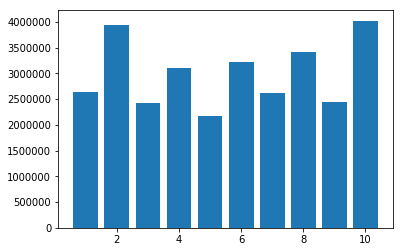

In [19]:
plt.bar(range(1,11,1), li_MSE)

In [23]:
dTab = []
for classValue1 in classLevels:
    dRow = []
    for classValue2 in classLevels:
        d = euclidean(mean_class[classValue1], mean_class[classValue2])
        dRow.append(d)
    dTab.append(dRow)
dMat = np.matrix(dTab)

In [40]:
def create2DMap(distanceMat, axes, axis_labels = None):
    ordResult = pcoa(distanceMat)
    coord_matrix = ordResult.samples.values.T
    prop_expl = ordResult.proportion_explained
    fig = plt.figure()
    xs = coord_matrix[axes[0]]
    ys = coord_matrix[axes[1]]
    plt.scatter(xs, ys)
    names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    for i in range(len(xs)):
        plt.annotate(names[i],(xs[i], ys[i]))
    if axis_labels is None:
        axis_labels = ['PC{} ({:.2%})'.format((axis+1), prop_expl[axis]) for axis in axes]
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    plt.axvline(x=0, color = 'k')
    plt.axhline(y=0, color = 'k')
    return fig


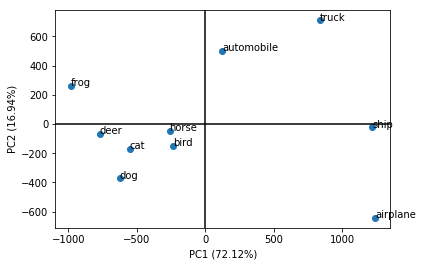

In [41]:
pcoa_2dMap = create2DMap(dMat, [0,1])

In [71]:
meanTomatirx = []
for classValue in classLevels:
    meanTomatirx.append(mean_class[classValue])
meanTomatirx=np.matrix(meanTomatirx)

In [78]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(meanTomatirx)
X_transformed.shape

(10, 2)

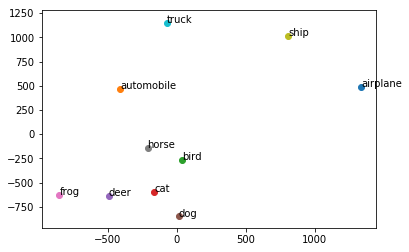

In [79]:
names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i][0], X_transformed[i][1])
    plt.annotate(names[i],(X_transformed[i][0], X_transformed[i][1]))

In [25]:
import PIL

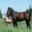

In [26]:
m = np.transpose(data_batch_1[b'data'][12].reshape((3, 32, 32)), (1,2,0))
PIL.Image.fromarray(m, mode = 'RGB')